In [2]:
# Now we will take things a step further and start identifying extremes
# It turns out, there are different ways of calculating an anomaly
# For our purposes of identifying persistent heat extremes, we will follow the methodology
# in the Chan et al. 2019 paper: https://doi.org/10.1038/s41612-022-00290-2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# inputs
tdir = '/work/Veeshan.Narinesingh/INTERNS_2024/ERA5/TEMPERATURE/'
tfileprefix = 'ERA5_temperature.model_level_137.daily.'

ny1=1979 # specify the first year of the data files
ny2=2019 # specify the last year of the data files


# specify the location of focus
locname='NYC' #specify a name for the location you are looking at
lonwant=360-74 # NY is 74 West longitude, but the longitude dimension goes from 0 to 360, so we do 360-74
latwant=40.71

savename= locname +'_hwstardates_and_durations.nc' #specify a savename for your file
print("Savename: " +savename)

Savename: NYC_hwstardates_and_durations.nc


In [3]:
# load in the temperature data for each year 
nyrs=ny2-ny1+1

time = np.zeros([365 * nyrs])
c1 = 0
c2 = 365

for yr in range(ny1,ny2 + 1):
    filenamet = tfileprefix + str(yr) + '.nc'
    ds = xr.open_dataset(tdir + filenamet)

    if yr == ny1:
        lat = ds.lat
        lon = ds.lon
        # preallocate t2m as an xarray
        var1np = np.zeros([365 * nyrs,np.size(lat),np.size(lon)])
        ratime = np.zeros([365 * nyrs])
        
    var1np[c1:c2,:,:] = ds.t[:365,:,:].values
    time[c1:c2] = np.arange(0,365,1) + 365 * (yr - ny1)
    ratime[c1:c2] = ds.time[:365]
    c1 = 1 * c2
    c2 = c2 + 365
var1 = xr.DataArray(data=var1np,dims=['time','lat','lon'],coords=dict(time=time, lat=lat, lon=lon))
varloc = var1.sel(lat=latwant,lon=lonwant,method='nearest') 




In [4]:
#First step in Chan's Algorithm is to do a 5-day smooth on the data to isolate persistent events
var1smooth5=varloc.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean

In [ ]:
#Here's a task to test your understanding. Make a plot of the raw a.k.a. full temperature field (we have done this in previous lesson)
#Then plot the 5 day smoothed field on the same figure.
#Describe what you see when comparing the two plots. Add a legend to your graph. 

In [7]:
var1smooth5=varloc.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
# turn into array and reshape to be # of  years by 365 days
var1smooth5np=var1smooth5.values.reshape((nyrs,365))
#now turn back into xarray
var1smooth5rs= xr.DataArray(data=var1smooth5np,dims=["year","day"],coords=dict(year=np.arange(ny1,ny2+1,1),day=np.arange(1,366,1)))
var1smooth5rs15day1=var1smooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
var1smooth5rs15day2=var1smooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean 
clim=var1smooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anom=var1smooth5rs-clim

Text(0, 0.5, 'Count')

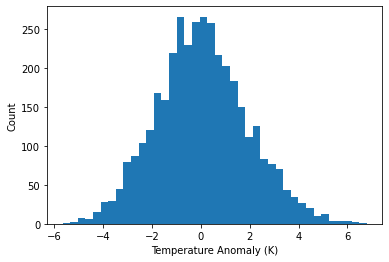

In [8]:
#Let's plot a histogram to get a sense of how these temperature anomalies are distributed
plt.hist(anomjja.values.flatten(),bins='auto')
plt.xlabel('Temperature Anomaly (K)')
plt.ylabel('Count')


In [9]:
#find 90th percentile for summer heat
anomjja=anom[:,151:242] #june 1st is idx 151, since it is the 152nd day of the year, Aug 31 is idx 242
thresh90=np.percentile((anomjja),90)
thresh90

2.4873581049633344

In [ ]:
# Tasks for you: 

#1. Calculate the 10th percentile.
#2. Calculate the 50th percentile.
#3. Calculate the 99th percentile.
#4. Calculate the 1st percentile.

#do your answers make sense according to the histogram?

In [10]:
#The rest of the code will now find and track the heat extremes. Basically it looks for all points in time that the temperature
#anomaly is above the 90th percentile threshold. Don't worry too much about this part, think of it as a black box.

#get hw dates at location 
timers=time.reshape((nyrs,365))
timersjja=timers[:,150:242] 

anomjjamat=anomjja.values

hwidcs=np.where(anomjjamat>thresh90)


hwdates=timersjja[hwidcs]

#find start dates
test = 2.0 * hwdates / hwdates
test[1:] = np.diff(hwdates)
independent_events = np.where(test != 1.0, 1.0, 0.0)
event_indices = independent_events * hwdates
event_startdates = event_indices[event_indices != 0].astype('int')

hwdatesint=hwdates.astype(int)
bimat = np.zeros(int(max(hwdates)))
for id in hwdatesint:
    bimat[int(id-1)]=1
    
from scipy.ndimage import label
labels, num_components = label(bimat)
print("Labels:")
print(labels)
print("Number of components:", num_components)

# Calculate the size of each label
label_sizes = np.bincount(labels.ravel())

durations=label_sizes[1:]       

#save start dates and durations
event_startdates_xr = xr.DataArray(data=event_startdates).rename('event_startdates')
durations_xr = xr.DataArray(data=durations).rename('event_duration')

Labels:
[ 0  0  0 ...  0 97 97]
Number of components: 97


Average Duration: 3.845360824742268 days


Text(0, 0.5, 'Count')

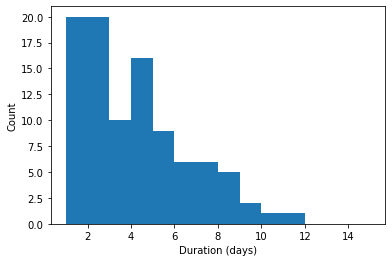

In [11]:
#Calculate the average heat extreme duration and make a histogram
print('Average Duration: ' + str(durations.mean()) + ' days')

plt.hist(durations,bins=list(range(1, 16))) #bins=list(range(1, 16)) produces histogram bins that go to 1 to 15
plt.xlabel('Duration (days)')
plt.ylabel('Count')

In [12]:
#Now we save the heat extreme start dates and durations in netcdf form

event_startdates_xr = xr.DataArray(data=event_startdates).rename('event_startdates')
durations_xr = xr.DataArray(data=durations).rename('event_duration')

# Create xarray Dataset
dataset = xr.Dataset(
    {
        "event_startdates": event_startdates_xr,
        "event_durations": durations_xr,
    }
)

dataset.to_netcdf(savename)